In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
import cmath
nsamples = 4_096
fs = 44_100

In [2]:
def generate_signal(samples = 2048, fs = 44_100):
    f0, f1, f2, f3, f4 = 1_000, 4_000, 6_000, 8_000, 17_357
    ts = 1 / fs
    time = np.linspace(0, samples*ts, samples)

    tone_0 = 1 * np.sin(2*np.pi*f0*time)
    tone_1 = 0.8 * np.sin(2*np.pi*f1*time)
    tone_2 = 2 * np.sin(2*np.pi*f2*time)
    tone_3 = 0.1 * np.sin(2*np.pi*f3*time)
    tone_4 = 0.3* np.sin(2*np.pi*f4*time)
    signal = tone_0 + tone_1 + tone_2*1j + tone_3*1j + tone_4*1j
    return signal

def compute_fft(data, fs = 44_100):
    samples = len(data)
    ts = 1 / fs
    spectrum = np.fft.fft(data)
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=ts))
    return spectrum, freqs

def init(n):
    omg = [cmath.exp(-2j * cmath.pi * i / n) for i in range(n)]
    return omg

def fft(x):
    a = np.copy(x)
    n = len(a)
    omg = init(n)

    lim = 0
    while (1 << lim) < n:
        lim += 1

    for i in range(n):
        t = 0
        for j in range(lim):
            if ((i >> j) & 1):
                t |= (1 << (lim - j - 1))
        if i < t:
            a[i], a[t] = a[t], a[i]  # i < t 的限制使得每对点只被交换一次（否则交换两次相当于没交换）
    # print("swap")
    # print(a[:8])

    l = 2
    while l <= n:   # stage循环 l为该stage子序列的长度
        m = l // 2  # 根据FFT特性，后一半的数值可由前一半的中间值计算得出
        for p in range(0, n, l):
            for i in range(m):
                t = omg[n // l * i] * a[p + i + m]
                # print('t=',t)
                a[p + i + m] = a[p + i] - t
                a[p + i] += t
        l *= 2
        
    return a

def fft_4k(signal):
    xx=[signal[i::4] for i in range(4)]
    x=[fft(xx[i]) for i in range(4)]
    for ii in range(4):
        for jj in range(1024):
            x[ii][jj]*=cmath.exp(-2j * cmath.pi * ii*jj / nsamples)
    a=[]
    for i in range(1024):
        res=fft(np.array([x[j][i] for j in range(4)]))
        a+=list(res)
        if i<4:
            print(res)
    b=[a[i::4] for i in range(4)]
    a=[]
    for ii in range(4):
        a+=b[ii]
    return np.array(a)

In [3]:
signal = generate_signal(nsamples, fs)
spectrum, freqs = compute_fft(signal, fs)
# spectrum_btf = fft(signal)
spectrum_btf=fft_4k(signal)
print(spectrum)

[ 4.23345774+3.70125613j -0.82840011-3.13506168j  0.32847814-2.28770035j
  0.97928979-1.9484531j ]
[ 4.23601699+3.74725322j -0.8253336 -3.12828299j  0.32894422-2.28727172j
  0.98067108-1.95325187j]
[ 4.23890819+3.79330897j -0.82227969-3.1215301j   0.32941003-2.2868538j
  0.98205895-1.95807279j]
[ 4.242132  +3.83945376j -0.81923828-3.1148028j   0.32987557-2.28644658j
  0.98345348-1.96291603j]
[4.23345774+3.70125613j 4.23601699+3.74725322j 4.23890819+3.79330897j ...
 4.22777126+3.56331359j 4.2293345 +3.60931667j 4.23123019+3.65528739j]


/home/bzy/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


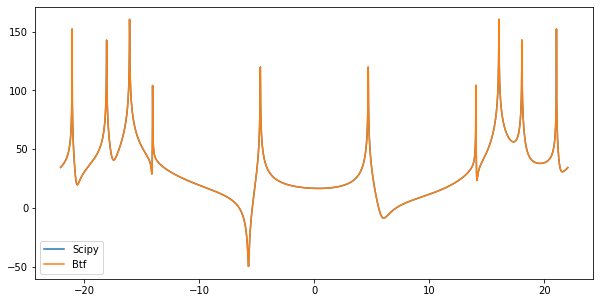

In [4]:
plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.plot(freqs / 1e3, 20*np.log(spectrum_btf), label="Btf")
plt.legend()

In [5]:
def vector2file_cint16(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxi = np.max(np.abs(data.imag))
    maxv = maxr if maxr > maxi else maxi
    if scale:
        # vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
        vscale = 64
    else:
        vscale = 1
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.int16(v.real)
            c = np.int16(v.imag)
            f.write("{} {} ".format(r, c))
            if (((i+1) % 4) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    
    return vscale

In [6]:
for i in range(4): 
    vscale=vector2file_cint16(signal[i::4], 'DataInFFT'+str(i)+'.txt', scale=True)
print(vscale)
# vector2file_cint16(signal, 'DataInFIR0.txt', scale=True)
# vector2file_cint16(spectrum, 'DataOutFFT0.txt', scale=True)

64


#### WAIT! ! ! AIE! ! !

In [7]:
import csv
def read_file(file: str, samples: int):
    value = np.zeros(samples, dtype=np.complex128)
    count = 0
    with open(file,'r') as f:
        reader = csv.reader(f, delimiter=" ")
        for line in reader:
            if 'T' in line[0]:
                continue
            for i in range(0, len(line), 2):
                if line[i] != '':
                    value[count] = np.int16(line[i]) + 1j* np.int16(line[i+1])
                    count = count + 1
    return value

In [38]:
# Use the output file from the AIE, now using SciPy file for simplicity
signal_read0 = read_file('DataOutFFT0.txt', nsamples//4)
signal_read1 = read_file('DataOutFFT1.txt', nsamples//4)
signal_read2 = read_file('DataOutFFT2.txt', nsamples//4)
signal_read3 = read_file('DataOutFFT3.txt', nsamples//4)
signal_read = np.concatenate([signal_read0, signal_read1, signal_read2, signal_read3])


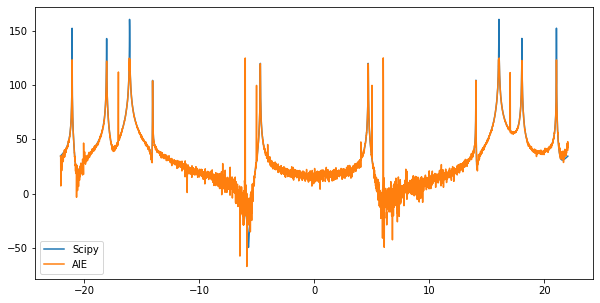

In [39]:
# scaled_in = read_file('DataInFFT0.txt', nsamples)
# spectrum, _ = compute_fft(scaled_in,fs)

plt.figure(figsize=(10,5))
plt.plot(freqs / 1e3, 20*np.log(spectrum), label="Scipy")
plt.plot(freqs / 1e3, 20*np.log(signal_read/vscale), label="AIE")
#plt.plot(freqs / 1e3, 20*np.log(signal_read), label="AIE")
plt.legend()

In [10]:
np.array_equal(spectrum, signal_read)

False

In [11]:
np.isclose(spectrum, signal_read, 2, 2)

array([ True,  True,  True, ...,  True,  True,  True])

In [12]:
error = spectrum - signal_read

In [13]:
np.max(np.abs(error.real))

29802.345408104928

In [14]:
np.max(np.abs(error.imag))

30928.471803758523

In [15]:
def findmax(fftnp, fftaie):
    print(f'Numpy: Max Real {np.max(np.abs(fftnp.real))}, Max Imag {np.max(np.abs(fftnp.imag))}')
    print(f'Numpy: Max Real {np.max(np.abs(fftaie.real))}, Max Imag {np.max(np.abs(fftaie.imag))}')

findmax(spectrum, signal_read)

Numpy: Max Real 1184.325379618681, Max Imag 2925.1613477124156
Numpy: Max Real 29803.0, Max Imag 31433.0


In [25]:
omg={{1024,0},{1023,-6},{1023,-12},{1023,-18},{1023,-25},{1023,-31},{1023,-37},{1023,-43},{1022,-50},{1022,-56},{1022,-62},{1021,-69},{1021,-75},{1020,-81},{1020,-87},{1019,-94},{1019,-100},{1018,-106},{1017,-112},{1017,-119},{1016,-125},{1015,-131},{1014,-137},{1013,-144},{1012,-150},{1011,-156},{1010,-162},{1009,-168},{1008,-175},{1007,-181},{1006,-187},{1005,-193},{1004,-199},{1003,-205},{1001,-212},{1000,-218},{999,-224},{997,-230},{996,-236},{994,-242},{993,-248},{991,-254},{990,-260},{988,-267},{986,-273},{985,-279},{983,-285},{981,-291},{979,-297},{978,-303},{976,-309},{974,-315},{972,-321},{970,-327},{968,-333},{966,-339},{964,-344},{962,-350},{959,-356},{957,-362},{955,-368},{953,-374},{950,-380},{948,-386},{946,-391},{943,-397},{941,-403},{938,-409},{936,-414},{933,-420},{930,-426},{928,-432},{925,-437},{922,-443},{920,-449},{917,-454},{914,-460},{911,-466},{908,-471},{906,-477},{903,-482},{900,-488},{897,-493},{894,-499},{890,-504},{887,-510},{884,-515},{881,-521},{878,-526},{875,-531},{871,-537},{868,-542},{865,-547},{861,-553},{858,-558},{854,-563},{851,-568},{847,-574},{844,-579},{840,-584},{837,-589},{833,-594},{829,-599},{826,-604},{822,-609},{818,-615},{814,-620},{811,-625},{807,-629},{803,-634},{799,-639},{795,-644},{791,-649},{787,-654},{783,-659},{779,-664},{775,-668},{771,-673},{767,-678},{762,-683},{758,-687},{754,-692},{750,-696},{745,-701},{741,-706},{737,-710},{732,-715},{728,-719},{724,-724},{719,-728},{715,-732},{710,-737},{706,-741},{701,-745},{696,-750},{692,-754},{687,-758},{683,-762},{678,-767},{673,-771},{668,-775},{664,-779},{659,-783},{654,-787},{649,-791},{644,-795},{639,-799},{634,-803},{629,-807},{625,-811},{620,-814},{615,-818},{609,-822},{604,-826},{599,-829},{594,-833},{589,-837},{584,-840},{579,-844},{574,-847},{568,-851},{563,-854},{558,-858},{553,-861},{547,-865},{542,-868},{537,-871},{531,-875},{526,-878},{521,-881},{515,-884},{510,-887},{504,-890},{499,-894},{493,-897},{488,-900},{482,-903},{477,-906},{471,-908},{466,-911},{460,-914},{454,-917},{449,-920},{443,-922},{437,-925},{432,-928},{426,-930},{420,-933},{414,-936},{409,-938},{403,-941},{397,-943},{391,-946},{386,-948},{380,-950},{374,-953},{368,-955},{362,-957},{356,-959},{350,-962},{344,-964},{339,-966},{333,-968},{327,-970},{321,-972},{315,-974},{309,-976},{303,-978},{297,-979},{291,-981},{285,-983},{279,-985},{273,-986},{267,-988},{260,-990},{254,-991},{248,-993},{242,-994},{236,-996},{230,-997},{224,-999},{218,-1000},{212,-1001},{205,-1003},{199,-1004},{193,-1005},{187,-1006},{181,-1007},{175,-1008},{168,-1009},{162,-1010},{156,-1011},{150,-1012},{144,-1013},{137,-1014},{131,-1015},{125,-1016},{119,-1017},{112,-1017},{106,-1018},{100,-1019},{94,-1019},{87,-1020},{81,-1020},{75,-1021},{69,-1021},{62,-1022},{56,-1022},{50,-1022},{43,-1023},{37,-1023},{31,-1023},{25,-1023},{18,-1023},{12,-1023},{6,-1023},{0,-1024},{-6,-1023},{-12,-1023},{-18,-1023},{-25,-1023},{-31,-1023},{-37,-1023},{-43,-1023},{-50,-1022},{-56,-1022},{-62,-1022},{-69,-1021},{-75,-1021},{-81,-1020},{-87,-1020},{-94,-1019},{-100,-1019},{-106,-1018},{-112,-1017},{-119,-1017},{-125,-1016},{-131,-1015},{-137,-1014},{-144,-1013},{-150,-1012},{-156,-1011},{-162,-1010},{-168,-1009},{-175,-1008},{-181,-1007},{-187,-1006},{-193,-1005},{-199,-1004},{-205,-1003},{-212,-1001},{-218,-1000},{-224,-999},{-230,-997},{-236,-996},{-242,-994},{-248,-993},{-254,-991},{-260,-990},{-267,-988},{-273,-986},{-279,-985},{-285,-983},{-291,-981},{-297,-979},{-303,-978},{-309,-976},{-315,-974},{-321,-972},{-327,-970},{-333,-968},{-339,-966},{-344,-964},{-350,-962},{-356,-959},{-362,-957},{-368,-955},{-374,-953},{-380,-950},{-386,-948},{-391,-946},{-397,-943},{-403,-941},{-409,-938},{-414,-936},{-420,-933},{-426,-930},{-432,-928},{-437,-925},{-443,-922},{-449,-920},{-454,-917},{-460,-914},{-466,-911},{-471,-908},{-477,-906},{-482,-903},{-488,-900},{-493,-897},{-499,-894},{-504,-890},{-510,-887},{-515,-884},{-521,-881},{-526,-878},{-531,-875},{-537,-871},{-542,-868},{-547,-865},{-553,-861},{-558,-858},{-563,-854},{-568,-851},{-574,-847},{-579,-844},{-584,-840},{-589,-837},{-594,-833},{-599,-829},{-604,-826},{-609,-822},{-615,-818},{-620,-814},{-625,-811},{-629,-807},{-634,-803},{-639,-799},{-644,-795},{-649,-791},{-654,-787},{-659,-783},{-664,-779},{-668,-775},{-673,-771},{-678,-767},{-683,-762},{-687,-758},{-692,-754},{-696,-750},{-701,-745},{-706,-741},{-710,-737},{-715,-732},{-719,-728},{-724,-724},{-728,-719},{-732,-715},{-737,-710},{-741,-706},{-745,-701},{-750,-696},{-754,-692},{-758,-687},{-762,-683},{-767,-678},{-771,-673},{-775,-668},{-779,-664},{-783,-659},{-787,-654},{-791,-649},{-795,-644},{-799,-639},{-803,-634},{-807,-629},{-811,-625},{-814,-620},{-818,-615},{-822,-609},{-826,-604},{-829,-599},{-833,-594},{-837,-589},{-840,-584},{-844,-579},{-847,-574},{-851,-568},{-854,-563},{-858,-558},{-861,-553},{-865,-547},{-868,-542},{-871,-537},{-875,-531},{-878,-526},{-881,-521},{-884,-515},{-887,-510},{-890,-504},{-894,-499},{-897,-493},{-900,-488},{-903,-482},{-906,-477},{-908,-471},{-911,-466},{-914,-460},{-917,-454},{-920,-449},{-922,-443},{-925,-437},{-928,-432},{-930,-426},{-933,-420},{-936,-414},{-938,-409},{-941,-403},{-943,-397},{-946,-391},{-948,-386},{-950,-380},{-953,-374},{-955,-368},{-957,-362},{-959,-356},{-962,-350},{-964,-344},{-966,-339},{-968,-333},{-970,-327},{-972,-321},{-974,-315},{-976,-309},{-978,-303},{-979,-297},{-981,-291},{-983,-285},{-985,-279},{-986,-273},{-988,-267},{-990,-260},{-991,-254},{-993,-248},{-994,-242},{-996,-236},{-997,-230},{-999,-224},{-1000,-218},{-1001,-212},{-1003,-205},{-1004,-199},{-1005,-193},{-1006,-187},{-1007,-181},{-1008,-175},{-1009,-168},{-1010,-162},{-1011,-156},{-1012,-150},{-1013,-144},{-1014,-137},{-1015,-131},{-1016,-125},{-1017,-119},{-1017,-112},{-1018,-106},{-1019,-100},{-1019,-94},{-1020,-87},{-1020,-81},{-1021,-75},{-1021,-69},{-1022,-62},{-1022,-56},{-1022,-50},{-1023,-43},{-1023,-37},{-1023,-31},{-1023,-25},{-1023,-18},{-1023,-12},{-1023,-6},}
omg_subarray = omg[::4]

TypeError: unhashable type: 'set'